# Lesson on microbial genomics and phylogenies using betacoronavirus/SARS-CoV-2 example

### About

Since the identification of SARS-CoV-2 virus and it's subsequent spread, there has been considerable discussion and uncertainty over it's origin. The genome of the newly emerging CoV consists of a single, positive-stranded RNA that is approximately 30k nucleotides long. The overall genome organization of the newly emerging CoV is similar to that of other coronaviruses. The newly sequenced virus genome encodes the open reading frames (ORFs) common to all betacoronaviruses, including  the spike-surface glycoprotein (S). This is essential for entry of virus particles into the cell. The S protein contains two functional domains: a receptor binding domain, and a second domain which contains sequences that mediate fusion of the viral and cell membranes. The S glycoprotein must be cleaved by cell proteases to enable exposure of the fusion sequences and hence is needed for cell entry. The receptor binding domain (RBD) in the spike protein is the most variable part of the virus genome. SARS-CoV-2 seems to have an RBD that may bind with high affinity to ACE2 from human and closely related mammals, but less so in other species. Six residues in the RBD appear to be critical for binding to the ACE2 receptor and determining host range. Five of these six residues are mutated in SARS-CoV-2 compared to its most closely related virus, RaTG13. The sequence comparison also shows the insertion of a furin cleavage sequence (PRRAR|SV) in SARS-CoV-2. This may alter the ability of the virus to infect cells in humans relative to the Bat form. Interested readers should check the links at the end of this page for further details. www.virology.ws has some easy to read articles on current research.

This page illustrates some microbial genomics methods using Python by replicating some of the results dicussed by [Andersen et al](http://virological.org/t/the-proximal-origin-of-sars-cov-2/398). It is important to note that the content of this page is the subject of current and ongoing research and should not be seen as indicating a special expertise in virology on the part of the author. 

This notebook is available at [this URL](https://github.com/dmnfarrell/teaching/blob/master/sarscov2/notebook.ipynb)

### Links

* http://virological.org/t/the-proximal-origin-of-sars-cov-2/398
* https://theprepared.com/blog/no-the-2019-ncov-genome-doesnt-actually-seem-engineered-from-hiv/
* https://www.ncbi.nlm.nih.gov/labs/virus/vssi
* https://biopython.org/wiki/Phylo

In [1]:
import os,sys,glob,random,subprocess
from importlib import reload
import pandas as pd
pd.options.display.width=180
import pylab as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import Phylo, AlignIO
import pathogenie
import pybioviz
from bokeh.io import show, output_notebook, output_file
output_notebook()
from ete3 import Tree, NodeStyle, TreeStyle, PhyloTree

Loading BokehJS ...

### We use the NCBI viruses database to download betacoronavirus sequences

NCBI Virus is a community portal for viral sequence data and it is easy to download nucleotide sequences for known betacoronavirus isolates here. [This link](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=Betacoronavirus,%20taxid:694002&Flags_csv=complete) links to all current sequences. Then we download the csv table and fasta file for these sequences. Subsets can then be used from this table, chosen by accession number or host name etc.

In [2]:
ncbidata = pd.read_csv('ncbi_betacoronavirus_25-02-20.csv')
#ncbidata = ncbidata.dropna(subset=['Host'])
print (len(ncbidata))
print (ncbidata.columns)
ncbidata['Release_Date'] = pd.to_datetime(ncbidata.Release_Date)

print (ncbidata.Host.value_counts()[:10])
#put sequences into a set of SeqRecord objects with Biopython
seqrecs = SeqIO.to_dict(SeqIO.parse('ncbi_betacoronavirus.fasta','fasta'))

1253
Index(['Details', 'Accession', 'Release_Date', 'Species', 'Genus', 'Family', 'Length', 'Nuc._Completeness', 'Genotype', 'Geo_Location', 'Host', 'Isolation_Source',
       'Collection_Date', 'BioSample', 'GenBank_Title'],
      dtype='object')
Homo sapiens                 468
Camelus dromedarius          188
Camelus                       76
Mus musculus                  60
Chiroptera                    22
Bos taurus                    22
Rhinolophus sinicus           19
Sus scrofa scrofa             11
Rattus argentiventer          10
Rhinolophus ferrumequinum      7
Name: Host, dtype: int64


## Examine the novel residues Spike glycoprotein of Sars-CoV-2 using a subset of closely related sequences

In [3]:
#accessions = ['DQ071615','MN611519','DQ412042','MT039873','KF186565','MK211377','JX993987','KU762338','MT106052','MN996527','KF530081']
accessions = ['KY417146','MN908947','MN996532','AY278741','MK211376']

subset = ncbidata[ncbidata.Accession.isin(accessions)]
cols= ['Accession','GenBank_Title','Host','Collection_Date']
subset[cols]

,Accession,GenBank_Title,Host,Collection_Date
4,MK211376,"Coronavirus BtRs-BetaCoV/YN2018B, complete genome",Rhinolophus affinis,2016-09
648,MN908947,Severe acute respiratory syndrome coronavirus ...,Homo sapiens,2019-12
846,AY278741,"SARS coronavirus Urbani, complete genome",NaN,NaN
1072,KY417146,"Bat SARS-like coronavirus isolate Rs4231, comp...",Rhinolophus sinicus,2013-04-17
1252,MN996532,"Bat coronavirus RaTG13, complete genome",Chiroptera,2013-07-24


### Annotate the nucleotide sequences and save in a dataframe

This function iterates over a dataframe that matches the accessions in the sequences we have loaded previously. This returns a dataframe with all the annotated sequences in one table. They can then be extracted based on whatever critierion we need. Note the annotated record for each file is written to a genbank file and it's loaded if present instead of re-running the annotation (even though the annotation only takes a couple of seconds).
The core method called here is `run_annotation` from a package that I wrote called `pygenefinder`. It performs a Prokka-type annotation on prokaryotic sequences and returns a dataframe and list of one or more SeqRecord objects. This function does use blast, hmmer, aragorn and prodigal but they can all be installed easily on Linux.

In [4]:
def annotate_files(df, outdir='annot'):
    """Annotate a set of sequences from a dataframe"""
    
    os.makedirs(outdir,exist_ok=True)
    res = []
    for i,row in df.iterrows():
        label = row.Accession
        #print(row)
        gbfile = os.path.join(outdir,label+'.gbk')
        if os.path.exists(gbfile):
            featdf = pathogenie.tools.genbank_to_dataframe(gbfile)
            featdf['sequence'] = featdf.translation
        else:
            seq = seqrecs[label]
            filename = os.path.join('temp',label+'.fasta')
            SeqIO.write(seq,filename,'fasta')
            featdf,recs = pathogenie.app.run_annotation(filename, threads=10, kingdom='viruses')
            pathogenie.tools.recs_to_genbank(recs, gbfile)
        featdf['label'] = label
        featdf['host'] = row.Host
        featdf['id'] = row.Species
        res.append(featdf)
    res = pd.concat(res)
    return res
    
annot = annotate_files(subset)

### Get a protein sequence of interest across all the annotations

`get_similar_sequences` simply takes the product name and finds it's sequence in each annotation from the dataframe produced previously. It's crude because it relies on the product name being the same in all annotations. A better method would be to find all orthologs at some level of sequence similarity. 

In [5]:
def get_similar_sequences(protname, annot):
    """Extract similar sequences by name from a set of annotations"""
    
    seqs = []
    for i,df in annot.groupby('label'):    
        s = df[df['product']==protname]
        if len(s)==0:
            continue
        s = s.iloc[0]
        #print (s)
        seq = SeqRecord(Seq(s.sequence),id=s.label)#,description=s.host)
        seqs.append(seq)
    return seqs

#print (seqs)
seqs = get_similar_sequences('Spike glycoprotein', annot)

## Interactive view of the alignment

We then just align those sequences with Clustal and show the alignment in the notebook interactively using another package called `pybioviz`. This works inside a Jupyter notebook, but there are lots of alignment viewers available. If you scroll along the sequence you will see the RBD and polybasic cleavage site in MN908947.

In [6]:
reload(pybioviz.plotters)
aln = pathogenie.tools.clustal_alignment(seqs=seqs)
#AlignIO.write(aln, 'aligned.fasta', 'fasta')
p = pybioviz.plotters.plot_sequence_alignment(aln, annot = {'polybasic cleavage site':690,'RBD contact residues':480})
#output_file('alignment.html')
show(p)

## Structural view of receptor binding domain

You can view models of the virus protein structures on SWISS-MODEL here: https://swissmodel.expasy.org/repository/species/2697049. They are based on the closest proteome and associated known structures. The particular model of interest here is the heterodimer Spike protein complexed with the human ACE receptor. Here we show a basic example of how to view the binding domain with PyMol. We can use Python to load and set up a scene focused on the interacting residues. The mutated residues are L455, F486, Q493, S494, N501, and Y505 using the coordinates of the model structure. The method `find_interacting_residues` selects the six key residues on chain C, the Spike protein and finds all residues in the receptor (chain D) within 4Å of any of these. This gives us a simple picture of the interaction. More in depth study of the structure is beyond the scope of this article.

In [25]:
from pymol import cmd
from IPython.display import Image

In [90]:
def find_interacting_residues():
    """Find set of residues"""
   
    from pymol import stored
    vals = {}
    residues = [455,486,493,494,501,505]
    offset=3
    for p in residues:
        sel1 = '(c. C and (donor or acceptor) and resi %s)' %p
        cmd.select('near','c. D within 4 of %s' %sel1)
        cmd.show('stick','near')
        cmd.color('red', 'near')
        stored.lst=[]
        cmd.iterate('near',"stored.lst.append((chain,resi,resn,name))")
        #print (stored.lst)       
        for r in stored.lst:         
            cmd.show('stick','resi %s' %r[1])
    return 

In [99]:
cmd.reinitialize()
cmd.load('model_spike.pdb')
cmd.orient()
#cmd.turn('x', -30)
cmd.turn('z', 50)
cmd.bg_color('white')
cmd.select('rbd', '(chain C and resi 455+486+493+494+501+505)')
cmd.zoom('rbd')
cmd.color('marine','chain C')
cmd.color('red','chain D')
cmd.show('sticks', 'rbd')
cmd.label('rbd and n. c' , 'resn+resi')
cmd.set('label_position', (1,2,3))
find_interacting_residues()
cmd.set('ray_trace_mode',3)
cmd.png('sarscov2_spike_ace.png', width=1200,dpi=150)
Image(filename='sarscov2_spike_ace.png')
cmd.save('sarscov2_spike_ace.pse')

## Show the broader relationships between animal hosts

In [199]:
hosts= ['Chiroptera','Tylonycteris pachypus','Rhinolophus ferrumequinum']
accessions = ['DQ071615','MN611519','DQ412042','MT039873','KF186565','MK211377','JX993987','KU762338','MT106052','MN996527','KF530081',
             'KY417146','MN908947','MN996532','AY278741','MK211376']

#subset2 = ncbidata[(ncbidata.Host.isin(hosts)) | (ncbidata.Release_Date>'2020-02-10')]
subset2 = ncbidata[ncbidata.Accession.isin(accessions)]
annot2 = annotate_files(subset2)
seqs = get_sequences('Spike glycoprotein', annot2)

### Make a tree from the alignment using phyml

This uses phyml to make an maximum likelihood tree.

In [30]:
def make_tree(infile, kind='nucl'):
    
    #aln = tools.clustal_alignment(seqs=seqs)
    cmd = 'mafft --retree 1 %s > aligned.fasta' %infile
    print (cmd)
    subprocess.check_output(cmd, shell=True)
    #AlignIO.write(aln, 'aligned.fasta', 'fasta')
    AlignIO.convert("aligned.fasta", "fasta", "aligned.phy", "phylip-relaxed")
    if kind=='nucl':
        cmd = 'mpirun -np 4 phyml-mpi -i aligned.phy -b 12 -m HKY85 -a e'
    else:
        cmd = 'mpirun -np 4 phyml-mpi -i aligned.phy -d aa -b 12 -m WAG -a e'
    tmp = subprocess.check_output(cmd, shell=True)
    t = Tree('aligned.phy_phyml_tree.txt', quoted_node_names=True)
    return t
#make_tree('')

In [ ]:
tree = Phylo.read("aligned.phy_phyml_tree.txt", "newick")
Phylo.draw_ascii(tree)

### View the tree with ete3

In [6]:
def color_leaves(t, colors):
    for l in t.iter_leaves():  
        if l.name in colors:
            clr = colors[l.name]
        else:
            clr='black'       
        ns = NodeStyle()
        ns["size"] = 12
        ns["fgcolor"] = clr
        l.set_style(ns)
        
def set_tiplabels(t, labelmap):
    for l in t.iter_leaves():
        #print (l.name)
        if l.name in labelmap:            
            l.name = labelmap[l.name]
    return 
            
def format_nodes(t):
    for n in t.traverse(): 
        ns = NodeStyle()
        ns["size"] = 0
        n.set_style(ns)

In [13]:
colors = {'Chiroptera': 'Red', 'Homo sapiens': 'Blue','Tylonycteris pachypus':'Orange','Rhinolophus ferrumequinum':'Brown'}
#res['color'] = res.host.apply(lambda x: colors[x],1)
#cmap = dict(zip(res.label,res.color))
#print (cmap)
labelmap = dict(zip(ncbidata.Accession,ncbidata.Species))

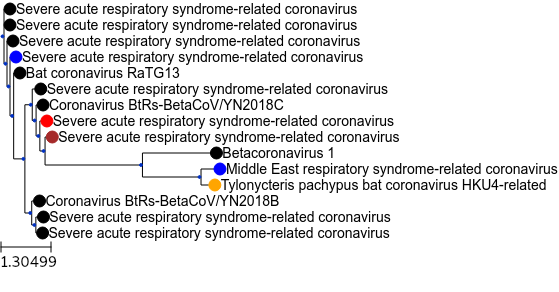

In [203]:
t = Tree('aligned.phy_phyml_tree.txt', quoted_node_names=True)
#alf=aln[:,650:700].format('fasta')
#t.link_to_alignment(alf)
ts = TreeStyle()
#ts.scale=180
#t.set_outgroup('MN611519')
#format_nodes(t)
color_leaves(t, cmap)
set_tiplabels(t, labelmap)

ts.show_leaf_name = True
t.render("%%inline", tree_style=ts)
#t.render("tree.png", dpi=150, tree_style=ts)

## GISAID sequences

In [7]:
gis = pd.read_csv('gisaid_cov2020.csv')
gis.columns
gis[:5]

,Accession ID,Virus name,Location,Collection date,Originating lab,Submitting lab,Authors
0,EPI_ISL_406959,hCoV-19/Italy/INMI1/2020,Europe / Italy / Rome,2020-01,unknown,"Virology Laboratory, INMI L. Spallanzani","Capobianchi,M.R., Carletti,F., Lalle,E., Bordi..."
1,EPI_ISL_402129,hCoV-19/Wuhan/WIV06/2019,Asia / China / Hubei / Wuhan,2019-12-30,Wuhan Jinyintan Hospital,"Wuhan Institute of Virology, Chinese Academy o...","Peng Zhou, Xing-Lou Yang, Ding-Yu Zhang, Lei Z..."
2,EPI_ISL_402130,hCoV-19/Wuhan/WIV07/2019,Asia / China / Hubei / Wuhan,2019-12-30,Wuhan Jinyintan Hospital,"Wuhan Institute of Virology, Chinese Academy o...","Peng Zhou, Xing-Lou Yang, Ding-Yu Zhang, Lei Z..."
3,EPI_ISL_403932,hCoV-19/Guangdong/20SF012/2020,Asia / China / Guandong / Shenzhen,2020-01-14,Guangdong Provincial Center for Diseases Contr...,"Department of Microbiology, Guangdong Provinci...","Min Kang, Jie Wu, Jing Lu, Tao Liu, Baisheng L..."
4,EPI_ISL_403933,hCoV-19/Guangdong/20SF013/2020,Asia / China / Guandong / Shenzhen,2020-01-15,Guangdong Provincial Center for Diseases Contr...,"Department of Microbiology, Guangdong Provinci...","Min Kang, Jie Wu, Jing Lu, Tao Liu, Baisheng L..."


In [9]:
names = glob.glob('gisaid/*.fasta')
recs=[]
for n in names:
    rec = list(SeqIO.parse(n,'fasta'))[0]  
    #print (rec.id)
    rec.id = rec.id.split('|')[0]
    recs.append(rec)
    
SeqIO.write(recs,'gisaid.fa','fasta')

31

In [31]:
t = make_tree('gisaid.fa')

mafft --retree 1 gisaid.fa > aligned.fasta


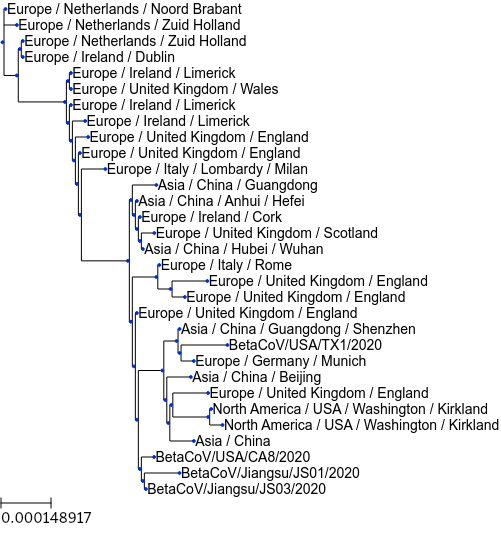

In [32]:
ts = TreeStyle()
ts.show_leaf_name = True
labelmap = dict(zip(gis['Virus name'],gis['Location']))
set_tiplabels(t, labelmap)
#color_leaves(t, cmap)
t.render("%%inline", tree_style=ts)

In [44]:
def annotate_gis_files(files):
    """Annotate a set of sequences from file list"""
    
    outdir = 'annot_gis'
    res = []
    df = pd.read_csv('gisaid_cov2020.csv')
    for filename in files:        
        rec = SeqIO.read(filename,'fasta')
        #print (rec.id, len(rec))
        loc,label = rec.id.split('|')      
        gbfile = os.path.join(outdir,label+'.gbk')
        if os.path.exists(gbfile):
            featdf = tools.genbank_to_dataframe(gbfile)
            featdf['sequence'] = featdf.translation
        else:
            featdf,recs = app.run_annotation(filename, threads=10, kingdom='viruses')
            tools.recs_to_genbank(recs, gbfile)
        featdf['label'] = label
        #featdf['id'] = row.Species
        res.append(featdf)
    res = pd.concat(res)
    return res

files = glob.glob('gisaid/*.fasta')
annot2 = annotate_gis_files(files)
annot2['product'].unique()

array(['Replicase polyprotein 1a', 'Replicase polyprotein 1ab',
       'Spike glycoprotein', 'Protein 3a', 'Membrane protein',
       'Protein 7a', 'hypothetical protein', 'Nucleoprotein',
       'Envelope small membrane protein'], dtype=object)

In [47]:
seqs = get_similar_sequences('Protein 7a', annot2)

In [ ]:
reload(pybioviz)
aln = tools.clustal_alignment(seqs=seqs)
#AlignIO.write(aln, 'aligned.fasta', 'fasta')
#print (gis)
labelmap = dict(zip(gis['Accession ID'],gis['Location']))
#print (labelmap.keys())
p=pybioviz.plot_sequence_alignment(aln, labels={})
#output_file('alignment.html')
show(p)

In [33]:
t = make_tree('temp.faa', kind='prot' )

mafft --retree 1 temp.faa > aligned.fasta


In [ ]:
set_tiplabels(t, labelmap)
t.render("%%inline")

In [ ]:
tree = Phylo.read("aligned.phy_phyml_tree.txt", "newick")
Phylo.draw_ascii(tree)